<a href="https://colab.research.google.com/github/kartikgill/The-GAN-Book/blob/main/Skill-09/Custom-Cartoon-GAN/Selfie2Anime-Modified-CartoonGAN/Custom-Cartoon-GAN-Selfie2Anime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Useful Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [ ]:
import tensorflow
print (tensorflow.__version__)

2.4.0


# Load and Unzip Data

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
!unzip /content/gdrive/MyDrive/GAN_datasets/selfie2anime.zip -d /

In [ ]:
import glob
faces = glob.glob('/trainA/*.jpg')
animes = glob.glob("/trainB/*.jpg")
faces_test = glob.glob('/testA/*.jpg')
animes_test = glob.glob("/testB/*.jpg")

In [ ]:
path = '/Users/k15/Downloads/selfie2anime/'

In [ ]:
import glob
faces = glob.glob(path + '/trainA/*.jpg')
animes = glob.glob(path + "/trainB/*.jpg")
faces_test = glob.glob(path + '/testA/*.jpg')
animes_test = glob.glob(path + "/testB/*.jpg")

In [ ]:
len(faces), len(animes), len(faces_test), len(animes_test)

(3400, 3400, 100, 100)

In [ ]:
import cv2
for file in faces[:10]:
    img = cv2.imread(file)
    print (img.shape)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


# Display Few Samples

Human Faces


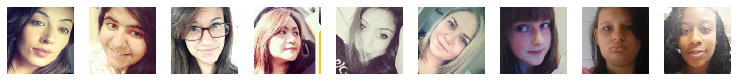

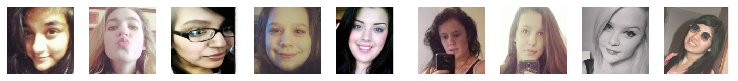

--------------------------------------------------------------------------------
Anime Faces


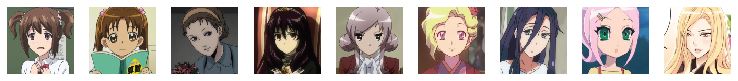

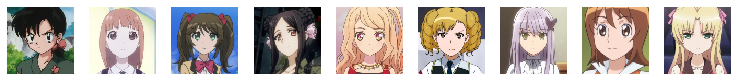

In [ ]:
print ("Human Faces")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(9):
        file = np.random.choice(faces)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128,128))
        plt.subplot(990 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

print ("-"*80)
print ("Anime Faces")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(9):
        file = np.random.choice(animes)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128,128))
        plt.subplot(990 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Define Generator Model (U-Net Like)

In [ ]:
import tensorflow_addons as tfa

In [ ]:
def encoder_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
        x = tfa.layers.InstanceNormalization()(x)
    return x

def decoder_layer(input_layer, skip_input, filters):
    #x = tensorflow.keras.layers.UpSampling2D(size=2)(input_layer)
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [ ]:
def make_generator():
    source_image = tensorflow.keras.layers.Input(shape=(128, 128, 3))
    target_style = tensorflow.keras.layers.Input(shape=(16, 16, 512))

    e1 = encoder_layer(source_image, 64, bn=False)
    e2 = encoder_layer(e1, 128)
    e3 = encoder_layer(e2, 256)
    # e4 = encoder_layer(e3, 256)
    e5 = encoder_layer(e3, 512)
    e6 = encoder_layer(e5, 512)
    e7 = encoder_layer(e6, 512)

    bottle_neck = tensorflow.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same')(e7)
    b = tensorflow.keras.layers.Activation('relu')(bottle_neck)

    d1 = decoder_layer(b, e7, 512)
    d2 = decoder_layer(d1, e6, 512)
    d3 = decoder_layer(d2, e5, 512)
    # d4 = decoder_layer(d3, e4, 256)
    d5 = decoder_layer(d3, e3, 256)
    d5 = tensorflow.keras.layers.Concatenate()([d5, target_style])
    d6 = decoder_layer(d5, e2, 128)
    d7 = decoder_layer(d6, e1, 64)

    decoded = tensorflow.keras.layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(d7)
    translated_image = tensorflow.keras.layers.Activation('tanh')(decoded)
    return source_image, target_style, translated_image

source_image, target_style, translated_image = make_generator()
generator_network = tensorflow.keras.models.Model(inputs=[source_image, target_style], outputs=translated_image)
print (generator_network.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   3136        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  131200      leaky_re_lu[0][0]                
______________________________________________________________________________________________

# Define Discriminator Network

In [ ]:
def my_conv_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
        x = tfa.layers.InstanceNormalization()(x)
    return x

In [ ]:
 def make_discriminator():
    target_image_input = tensorflow.keras.layers.Input(shape=(128, 128, 3))

    x = my_conv_layer(target_image_input, 64, bn=False)
    x = my_conv_layer(x, 128)
    x = my_conv_layer(x, 256)
    # x = my_conv_layer(x, 512)
    x = my_conv_layer(x, 512)

    patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), strides=(1,1), padding='same')(x)
    return target_image_input, patch_features


target_image_input, patch_features = make_discriminator()
discriminator_network = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)

print (discriminator_network.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
instance_normalization_11 (I (None, 32, 32, 128)       256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       5245

In [ ]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# Load and Extract VGG features

In [ ]:
image_input = tensorflow.keras.layers.Input(shape=(128, 128, 3))

pre_trained_vgg = tensorflow.keras.applications.vgg19.VGG19(weights='imagenet', input_shape=(128, 128, 3), include_top=False)
pre_trained_vgg_model = tensorflow.keras.models.Model(inputs=pre_trained_vgg.input, outputs=pre_trained_vgg.get_layer('block4_conv4').output)

pre_trained_image_feautures = pre_trained_vgg_model(image_input)

custom_vgg = tensorflow.keras.models.Model(inputs=image_input, outputs=pre_trained_image_feautures)
print (custom_vgg.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
model_2 (Functional)         (None, 16, 16, 512)       10585152  
Total params: 10,585,152
Trainable params: 10,585,152
Non-trainable params: 0
_________________________________________________________________
None


# Define Customized-Face2Anime-GAN

In [ ]:
source_image = tensorflow.keras.layers.Input(shape=(128, 128, 3))
target_features = tensorflow.keras.layers.Input(shape=(16, 16, 512))

# Domain Transfer
custom_vgg.trainable=False
fake_anime = generator_network([source_image, target_features])
  
discriminator_network.trainable=False

# Tell Real vs Fake
real_vs_fake = discriminator_network(fake_anime)

face2anime_gan = tensorflow.keras.models.Model(inputs =[source_image, target_features], outputs = [real_vs_fake, fake_anime, fake_anime])
face2anime_gan.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 16, 16, 512) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128, 128, 3)  42882051    input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 8, 8, 1)      2766529     model[0][0]                

# Custom Content Loss (vgg features Loss)

In [ ]:
def custom_content_loss(y_true, y_pred):
    custom_vgg.trainable=False
    y_true_features = custom_vgg(y_true)
    y_pred_features = custom_vgg(y_pred)
    content_loss = tensorflow.keras.losses.mean_absolute_error(y_true_features, y_pred_features)
    return content_loss

def custom_content_loss2(y_true, y_pred):
    custom_vgg.trainable=False
    y_true_features = y_true
    y_pred_features = custom_vgg(y_pred)
    content_loss = tensorflow.keras.losses.mean_absolute_error(y_true_features, y_pred_features)
    return content_loss

# Compiling Models

In [ ]:
face2anime_gan.compile(loss=['mse', custom_content_loss, custom_content_loss],\
                       optimizer=adam_optimizer, loss_weights=[1, 1, 0.1])

# Define Data Generators

In [ ]:
def faces_to_animes(faces, styles, generator_network):
    styles = custom_vgg(styles)
    generated_samples = generator_network.predict_on_batch([faces, styles])
    return generated_samples

def get_training_samples(batch_size):
    random_files = np.random.choice(faces, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append((img-127.5)/127.5)
    face_images = np.array(images)

    random_files = np.random.choice(animes, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append((img-127.5)/127.5)
    anime_images = np.array(images)
    return face_images, anime_images

def show_generator_results(generator_network):
    images = []
    styles = []
    for j in range(7):
        file = np.random.choice(faces_test)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append(img)

        file = np.random.choice(animes_test)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        styles.append(img)

    print ('Human Face Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(770 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    # print ('Style Images')
    # plt.figure(figsize=(13, 13))
    # for j, img in enumerate(styles):
    #     plt.subplot(770 + 1 + j)
    #     plt.imshow(img)
    #     plt.axis('off')
    #     #plt.title(trainY[i])
    # plt.show()

    print ('Customized Anime Version')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        img = (img-127.5)/127.5
        style = (styles[j]-127.5)/127.5
        output = faces_to_animes(np.array([img]), np.array([style]), generator_network)[0]
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Training Face2Anime-GAN

In [ ]:
len(faces), len(animes)

(3400, 3400)

In [ ]:
epochs = 500
batch_size = 1
steps = 3400

for i in range(0, epochs):
    # if i%1 == 0:
    #     show_generator_results(generator_network)
    for j in range(steps): 
        if j%200 == 0:
            show_generator_results(generator_network) 
            generator_network.save(path + "weights/model_" + str(i) + "_" + str(j))

        human_faces, anime_faces = get_training_samples(batch_size)

        fake_patch = np.zeros((batch_size, 8, 8, 1))
        real_patch = np.ones((batch_size, 8, 8, 1))
        
        custom_vgg.trainable=False
        styles = custom_vgg(anime_faces)
        fake_anime_faces = generator_network([human_faces, styles])
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d_real = discriminator_network.train_on_batch(anime_faces, real_patch)
        loss_d_fake = discriminator_network.train_on_batch(fake_anime_faces, fake_patch)

        loss_d = np.add(loss_d_real, loss_d_fake)/2.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        discriminator_network.trainable=False
        # custom_vgg.trainable=False
        # y_true_features1 = custom_vgg(human_faces)
        # y_true_features2 = custom_vgg(anime_faces)

        # avg_features = np.add(y_true_features1, y_true_features2)/2.0

        # Updating Generator weights
        loss_g = face2anime_gan.train_on_batch([human_faces, styles],[real_patch, human_faces, anime_faces])
        
        if j%100 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g[0]))
            